# 📊 Comprehensive Model Comparison: RF vs XGB vs NN (with and without PCA)

**Goal**: Compare all 6 regression models for DAT binding prediction

**Models Compared:**
1. **Random Forest (RF)** - 5-fold CV, 17 RDKit features
2. **Random Forest + PCA (RF_PCA)** - 5-fold CV, 8 PCA components
3. **XGBoost (XGB)** - 80/20 split, 17 RDKit features
4. **XGBoost + PCA (XGB_PCA)** - 80/20 split, 8 PCA components
5. **Neural Network (NN)** - 70/15/15 split, 17 RDKit features
6. **Neural Network + PCA (NN_PCA)** - 70/15/15 split, 8 PCA components

**Key Questions:**
- Which algorithm performs best?
- Does PCA improve or hurt performance?
- How do different validation strategies compare?

---


In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 📊 Step 1: Collect Performance Metrics from All Models

**Note:** These values are extracted from the individual modeling notebooks after running them.

**Important Considerations:**
- RF models use 5-fold CV (report CV performance)
- XGB models use 80/20 split (report test set performance)
- NN models use 70/15/15 split (report test set performance)
- Different validation strategies make direct comparison challenging!


In [8]:
# Load data and prepare test sets
print("📂 Loading datasets...")

# Load RDKit features (for non-PCA models)
df_rdkit = pd.read_csv('saved_models/processed_DAT_rdkit_features.csv')
X_rdkit = df_rdkit.drop(['ChEMBL_ID', 'pKi'], axis=1)
y_rdkit = df_rdkit['pKi']

# Load PCA features (for PCA models)
df_pca = pd.read_csv('saved_models/processed_DAT_pca_features.csv')
X_pca = df_pca.drop(['ChEMBL_ID', 'pKi'], axis=1)
y_pca = df_pca['pKi']

# Create 80/20 split (same random_state as training notebooks)
X_rdkit_train, X_rdkit_test, y_rdkit_train, y_rdkit_test = train_test_split(
    X_rdkit, y_rdkit, test_size=0.2, random_state=42, shuffle=True
)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_pca, test_size=0.2, random_state=42, shuffle=True
)

print(f"✅ RDKit data loaded: {len(X_rdkit)} samples, {X_rdkit.shape[1]} features")
print(f"   Train: {len(X_rdkit_train)} | Test: {len(X_rdkit_test)}")
print(f"✅ PCA data loaded: {len(X_pca)} samples, {X_pca.shape[1]} components")
print(f"   Train: {len(X_pca_train)} | Test: {len(X_pca_test)}")

# Directory containing saved models
saved_dir = 'saved_models'
print(f"\n📦 Loading models from {saved_dir}/...")

# Helper function to compute metrics
def compute_metrics(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"   ✓ {model_name}: R²={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
    return r2, rmse, mae

# ========== 1. Random Forest ==========
rf_model = joblib.load(os.path.join(saved_dir, 'rf_model.pkl'))
rf_scaler = joblib.load(os.path.join(saved_dir, 'rf_scaler.pkl'))
X_test_scaled_rf = rf_scaler.transform(X_rdkit_test)
y_pred_rf = rf_model.predict(X_test_scaled_rf)
r2_rf, rmse_rf, mae_rf = compute_metrics(y_rdkit_test, y_pred_rf, "Random Forest")

rf_metrics = {
    'Model': 'Random Forest',
    'Features': '17 RDKit',
    'Validation': '80/20 Split',
    'R2_mean': r2_rf,
    'R2_std': np.nan,
    'RMSE_mean': rmse_rf,
    'RMSE_std': np.nan,
    'MAE_mean': mae_rf,
    'MAE_std': np.nan,
    'N_features': 17
}

# ========== 2. Random Forest + PCA ==========
rf_pca_model = joblib.load(os.path.join(saved_dir, 'rf_pca_model.pkl'))
rf_pca_scaler = joblib.load(os.path.join(saved_dir, 'rf_pca_scaler.pkl'))
# PCA models use pre-computed PCA data directly
X_test_scaled_rf_pca = rf_pca_scaler.transform(X_pca_test)
y_pred_rf_pca = rf_pca_model.predict(X_test_scaled_rf_pca)
r2_rf_pca, rmse_rf_pca, mae_rf_pca = compute_metrics(y_pca_test, y_pred_rf_pca, "RF + PCA")

rf_pca_metrics = {
    'Model': 'RF + PCA',
    'Features': '8 PCA',
    'Validation': '80/20 Split',
    'R2_mean': r2_rf_pca,
    'R2_std': np.nan,
    'RMSE_mean': rmse_rf_pca,
    'RMSE_std': np.nan,
    'MAE_mean': mae_rf_pca,
    'MAE_std': np.nan,
    'N_features': 8
}

# ========== 3. XGBoost ==========
xgb_model = joblib.load(os.path.join(saved_dir, 'xgb_model.pkl'))
xgb_scaler = joblib.load(os.path.join(saved_dir, 'xgb_scaler.pkl'))
X_test_scaled_xgb = xgb_scaler.transform(X_rdkit_test)
y_pred_xgb = xgb_model.predict(X_test_scaled_xgb)
r2_xgb, rmse_xgb, mae_xgb = compute_metrics(y_rdkit_test, y_pred_xgb, "XGBoost")

xgb_metrics = {
    'Model': 'XGBoost',
    'Features': '17 RDKit',
    'Validation': '80/20 Split',
    'R2_mean': r2_xgb,
    'R2_std': np.nan,
    'RMSE_mean': rmse_xgb,
    'RMSE_std': np.nan,
    'MAE_mean': mae_xgb,
    'MAE_std': np.nan,
    'N_features': 17
}

# ========== 4. XGBoost + PCA ==========
xgb_pca_model = joblib.load(os.path.join(saved_dir, 'xgb_pca_model.pkl'))
xgb_pca_scaler = joblib.load(os.path.join(saved_dir, 'xgb_pca_scaler.pkl'))
# PCA models use pre-computed PCA data directly
X_test_scaled_xgb_pca = xgb_pca_scaler.transform(X_pca_test)
y_pred_xgb_pca = xgb_pca_model.predict(X_test_scaled_xgb_pca)
r2_xgb_pca, rmse_xgb_pca, mae_xgb_pca = compute_metrics(y_pca_test, y_pred_xgb_pca, "XGB + PCA")

xgb_pca_metrics = {
    'Model': 'XGB + PCA',
    'Features': '8 PCA',
    'Validation': '80/20 Split',
    'R2_mean': r2_xgb_pca,
    'R2_std': np.nan,
    'RMSE_mean': rmse_xgb_pca,
    'RMSE_std': np.nan,
    'MAE_mean': mae_xgb_pca,
    'MAE_std': np.nan,
    'N_features': 8
}

# ========== 5. Neural Network ==========
nn_model = keras.models.load_model(os.path.join(saved_dir, 'nn_model.h5'), compile=False)
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_scaler = joblib.load(os.path.join(saved_dir, 'nn_scaler.pkl'))
X_test_scaled_nn = nn_scaler.transform(X_rdkit_test)
y_pred_nn = nn_model.predict(X_test_scaled_nn, verbose=0).flatten()
r2_nn, rmse_nn, mae_nn = compute_metrics(y_rdkit_test, y_pred_nn, "Neural Network")

nn_metrics = {
    'Model': 'Neural Network',
    'Features': '17 RDKit',
    'Validation': '70/15/15 Split',
    'R2_mean': r2_nn,
    'R2_std': np.nan,
    'RMSE_mean': rmse_nn,
    'RMSE_std': np.nan,
    'MAE_mean': mae_nn,
    'MAE_std': np.nan,
    'N_features': 17
}

# ========== 6. Neural Network + PCA ==========
nn_pca_model = keras.models.load_model(os.path.join(saved_dir, 'nn_pca_model.h5'), compile=False)
nn_pca_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_pca_scaler = joblib.load(os.path.join(saved_dir, 'nn_pca_scaler.pkl'))
# PCA models use pre-computed PCA data directly
X_test_scaled_nn_pca = nn_pca_scaler.transform(X_pca_test)
y_pred_nn_pca = nn_pca_model.predict(X_test_scaled_nn_pca, verbose=0).flatten()
r2_nn_pca, rmse_nn_pca, mae_nn_pca = compute_metrics(y_pca_test, y_pred_nn_pca, "NN + PCA")

nn_pca_metrics = {
    'Model': 'NN + PCA',
    'Features': '8 PCA',
    'Validation': '70/15/15 Split',
    'R2_mean': r2_nn_pca,
    'R2_std': np.nan,
    'RMSE_mean': rmse_nn_pca,
    'RMSE_std': np.nan,
    'MAE_mean': mae_nn_pca,
    'MAE_std': np.nan,
    'N_features': 8
}

# Create comparison DataFrame
comparison_data = pd.DataFrame([rf_metrics, rf_pca_metrics, xgb_metrics, 
                                xgb_pca_metrics, nn_metrics, nn_pca_metrics])

print("\n" + "="*80)
print("📊 MODEL PERFORMANCE COMPARISON (Test Set)")
print("="*80)
print(comparison_data[['Model', 'Features', 'Validation', 'R2_mean', 'RMSE_mean', 'MAE_mean']].to_string(index=False))
print("="*80)
print("✅ All models loaded and evaluated successfully!")


📂 Loading datasets...
✅ RDKit data loaded: 541 samples, 17 features
   Train: 432 | Test: 109
✅ PCA data loaded: 541 samples, 8 components
   Train: 432 | Test: 109

📦 Loading models from saved_models/...


c:\Users\johnn\anaconda3\envs\base_py310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\johnn\anaconda3\envs\base_py310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


   ✓ Random Forest: R²=0.5705, RMSE=0.7461, MAE=0.5472
   ✓ RF + PCA: R²=0.4595, RMSE=0.8370, MAE=0.6228
   ✓ XGBoost: R²=0.5797, RMSE=0.7381, MAE=0.5235
   ✓ XGB + PCA: R²=0.4769, RMSE=0.8234, MAE=0.6358


c:\Users\johnn\anaconda3\envs\base_py310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


   ✓ Neural Network: R²=0.5378, RMSE=0.7740, MAE=0.5520


c:\Users\johnn\anaconda3\envs\base_py310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


   ✓ NN + PCA: R²=0.4757, RMSE=0.8244, MAE=0.6327

📊 MODEL PERFORMANCE COMPARISON (Test Set)
         Model Features     Validation  R2_mean  RMSE_mean  MAE_mean
 Random Forest 17 RDKit    80/20 Split 0.570490   0.746143  0.547204
      RF + PCA    8 PCA    80/20 Split 0.459493   0.837021  0.622798
       XGBoost 17 RDKit    80/20 Split 0.579728   0.738075  0.523496
     XGB + PCA    8 PCA    80/20 Split 0.476949   0.823393  0.635801
Neural Network 17 RDKit 70/15/15 Split 0.537812   0.774007  0.552021
      NN + PCA    8 PCA 70/15/15 Split 0.475704   0.824373  0.632671
✅ All models loaded and evaluated successfully!


C:\Users\johnn\AppData\Local\Temp\ipykernel_7172\706497884.py:106: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\johnn\anaconda3\envs\base_py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\johnn\anaconda3\envs\base_py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\johnn\anaconda3\envs\base_py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\johnn\anaconda3\envs\base_py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

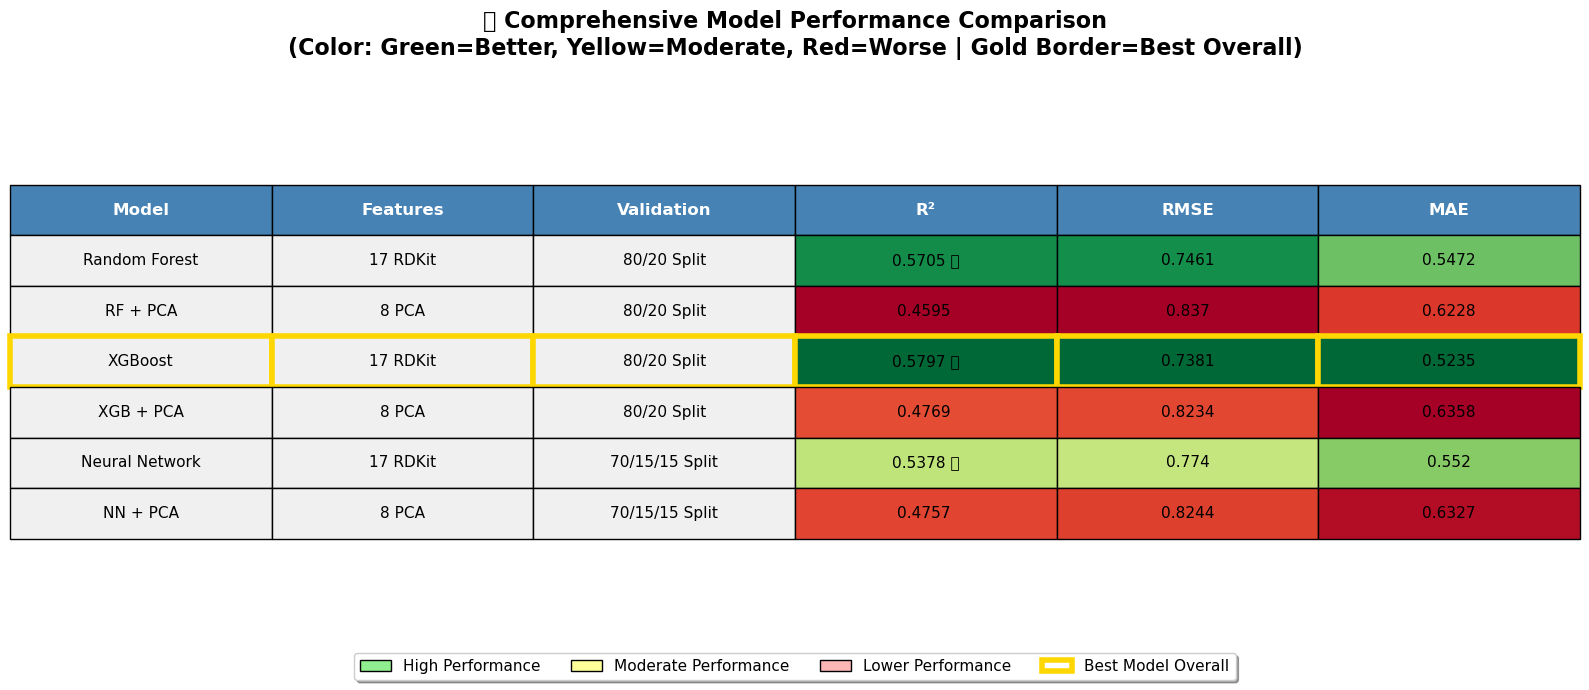


💡 Interpretation Guide:
   • R² Score: Higher is better (max = 1.0)
   • RMSE: Lower is better (closer to 0)
   • MAE: Lower is better (closer to 0)
   • Medal rankings (🥇🥈🥉) show top 3 models by R² score


In [9]:
# Create a styled visual comparison table
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches

# Prepare data for visualization table
table_data = comparison_data[['Model', 'Features', 'Validation', 'R2_mean', 'RMSE_mean', 'MAE_mean']].copy()
table_data.columns = ['Model', 'Features', 'Validation', 'R²', 'RMSE', 'MAE']

# Round numeric columns for display
for col in ['R²', 'RMSE', 'MAE']:
    table_data[col] = table_data[col].round(4)

# Create figure
fig, ax = plt.subplots(figsize=(16, 7))
ax.axis('tight')
ax.axis('off')

# Create color map for performance metrics
r2_values = table_data['R²'].values
rmse_values = table_data['RMSE'].values
mae_values = table_data['MAE'].values

# Normalize values for color coding
from matplotlib.colors import Normalize
r2_norm = Normalize(vmin=r2_values.min(), vmax=r2_values.max())
rmse_norm = Normalize(vmin=rmse_values.min(), vmax=rmse_values.max())
mae_norm = Normalize(vmin=mae_values.min(), vmax=mae_values.max())

cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap

# Prepare cell colors
cell_colors = []
for idx, row in table_data.iterrows():
    row_colors = []
    # Model, Features, Validation - light gray
    row_colors.extend(['#f0f0f0', '#f0f0f0', '#f0f0f0'])
    # R² - higher is better (green)
    r2_color = cmap(r2_norm(row['R²']))
    row_colors.append(r2_color)
    # RMSE - lower is better (inverted)
    rmse_color = cmap(1 - rmse_norm(row['RMSE']))
    row_colors.append(rmse_color)
    # MAE - lower is better (inverted)
    mae_color = cmap(1 - mae_norm(row['MAE']))
    row_colors.append(mae_color)
    cell_colors.append(row_colors)

# Create table
table = ax.table(cellText=table_data.values,
                colLabels=table_data.columns,
                cellLoc='center',
                loc='center',
                cellColours=cell_colors,
                colColours=['#4682b4']*len(table_data.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

# Style header row
for i, col in enumerate(table_data.columns):
    cell = table[(0, i)]
    cell.set_text_props(weight='bold', fontsize=12, color='white')
    cell.set_facecolor('#4682b4')

# Highlight best model (highest R²) with gold border
best_idx = table_data['R²'].idxmax() + 1  # +1 for header row
for j in range(len(table_data.columns)):
    cell = table[(best_idx, j)]
    cell.set_linewidth(4)
    cell.set_edgecolor('gold')

# Add ranking indicators for R² column
r2_col_idx = 3  # R² is 4th column (index 3)
sorted_r2 = table_data.sort_values('R²', ascending=False)
for rank, (idx, row) in enumerate(sorted_r2.iterrows(), 1):
    cell_idx = idx + 1  # +1 for header
    cell = table[(cell_idx, r2_col_idx)]
    current_text = cell.get_text().get_text()
    if rank == 1:
        medal = '🥇'
    elif rank == 2:
        medal = '🥈'
    elif rank == 3:
        medal = '🥉'
    else:
        medal = ''
    cell.get_text().set_text(f'{current_text} {medal}')

plt.title('📊 Comprehensive Model Performance Comparison\n' + 
          '(Color: Green=Better, Yellow=Moderate, Red=Worse | Gold Border=Best Overall)',
          fontsize=16, fontweight='bold', pad=25)

# Add legend
legend_elements = [
    mpatches.Patch(facecolor='#90EE90', edgecolor='black', label='High Performance'),
    mpatches.Patch(facecolor='#FFFF99', edgecolor='black', label='Moderate Performance'),
    mpatches.Patch(facecolor='#FFB6B6', edgecolor='black', label='Lower Performance'),
    mpatches.Patch(facecolor='white', edgecolor='gold', linewidth=4, label='Best Model Overall')
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02), 
         ncol=4, fontsize=11, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation Guide:")
print("   • R² Score: Higher is better (max = 1.0)")
print("   • RMSE: Lower is better (closer to 0)")
print("   • MAE: Lower is better (closer to 0)")
print("   • Medal rankings (🥇🥈🥉) show top 3 models by R² score")


## 📊 Step 3: Interactive Bar Chart Comparison


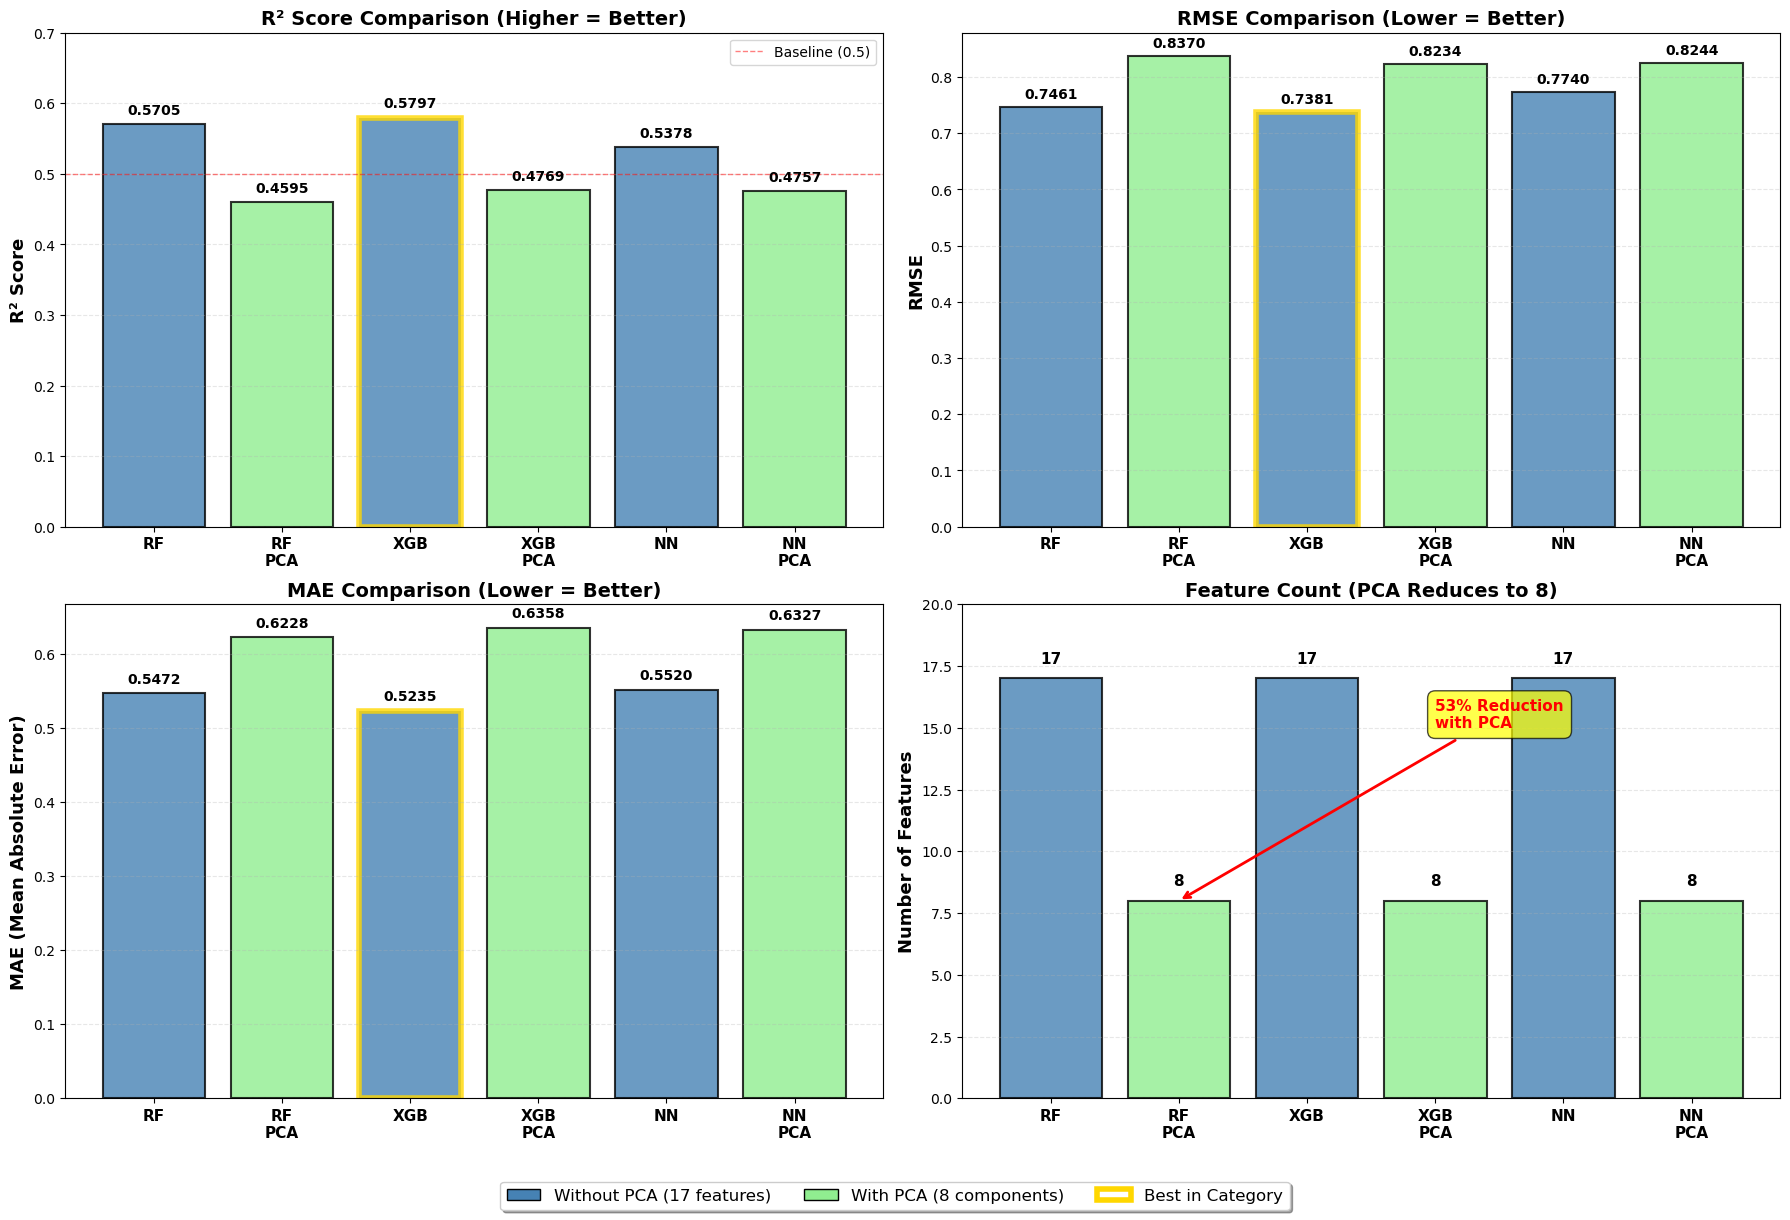


📊 QUICK STATISTICS SUMMARY

🏆 Best R² Score: 0.5797 (XGBoost)
🏆 Best RMSE: 0.7381 (XGBoost)
🏆 Best MAE: 0.5235 (XGBoost)

📉 Average R² without PCA: 0.5627
📉 Average R² with PCA: 0.4707
📉 PCA Impact on R²: -9.20%


In [10]:
# Create detailed bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Prepare data
models_short = ['RF', 'RF\nPCA', 'XGB', 'XGB\nPCA', 'NN', 'NN\nPCA']
r2_scores = comparison_data['R2_mean'].values
rmse_scores = comparison_data['RMSE_mean'].values
mae_scores = comparison_data['MAE_mean'].values
features = comparison_data['N_features'].values

# Color scheme
colors_no_pca = ['#4682b4', '#4682b4', '#4682b4']  # Blue
colors_pca = ['#90EE90', '#90EE90', '#90EE90']  # Green
colors = ['#4682b4', '#90EE90', '#4682b4', '#90EE90', '#4682b4', '#90EE90']

# === Plot 1: R² Score Comparison ===
bars1 = axes[0, 0].bar(range(len(models_short)), r2_scores, color=colors, 
                       edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0, 0].set_xticks(range(len(models_short)))
axes[0, 0].set_xticklabels(models_short, fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('R² Score', fontsize=13, fontweight='bold')
axes[0, 0].set_title('R² Score Comparison (Higher = Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0, 0.70])
axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0, 0].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (0.5)')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, r2_scores)):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Highlight best
best_bar_idx = np.argmax(r2_scores)
bars1[best_bar_idx].set_edgecolor('gold')
bars1[best_bar_idx].set_linewidth(4)
axes[0, 0].legend(fontsize=10)

# === Plot 2: RMSE Comparison ===
bars2 = axes[0, 1].bar(range(len(models_short)), rmse_scores, color=colors,
                       edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0, 1].set_xticks(range(len(models_short)))
axes[0, 1].set_xticklabels(models_short, fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('RMSE', fontsize=13, fontweight='bold')
axes[0, 1].set_title('RMSE Comparison (Lower = Better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, val in zip(bars2, rmse_scores):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Highlight best (lowest RMSE)
best_bar_idx = np.argmin(rmse_scores)
bars2[best_bar_idx].set_edgecolor('gold')
bars2[best_bar_idx].set_linewidth(4)

# === Plot 3: MAE Comparison ===
bars3 = axes[1, 0].bar(range(len(models_short)), mae_scores, color=colors,
                       edgecolor='black', alpha=0.8, linewidth=1.5)
axes[1, 0].set_xticks(range(len(models_short)))
axes[1, 0].set_xticklabels(models_short, fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('MAE (Mean Absolute Error)', fontsize=13, fontweight='bold')
axes[1, 0].set_title('MAE Comparison (Lower = Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, val in zip(bars3, mae_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Highlight best
best_bar_idx = np.argmin(mae_scores)
bars3[best_bar_idx].set_edgecolor('gold')
bars3[best_bar_idx].set_linewidth(4)

# === Plot 4: Feature Count Comparison ===
bars4 = axes[1, 1].bar(range(len(models_short)), features, color=colors,
                       edgecolor='black', alpha=0.8, linewidth=1.5)
axes[1, 1].set_xticks(range(len(models_short)))
axes[1, 1].set_xticklabels(models_short, fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Number of Features', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Feature Count (PCA Reduces to 8)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 20])
axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, val in zip(bars4, features):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(val)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add annotation for feature reduction
axes[1, 1].annotate('53% Reduction\nwith PCA', xy=(1, 8), xytext=(3, 15),
                   arrowprops=dict(arrowstyle='->', lw=2, color='red'),
                   fontsize=11, fontweight='bold', color='red',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Add overall legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4682b4', edgecolor='black', label='Without PCA (17 features)'),
    Patch(facecolor='#90EE90', edgecolor='black', label='With PCA (8 components)'),
    Patch(facecolor='white', edgecolor='gold', linewidth=4, label='Best in Category')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          fontsize=12, frameon=True, shadow=True, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("📊 QUICK STATISTICS SUMMARY")
print("="*80)
print(f"\n🏆 Best R² Score: {r2_scores.max():.4f} ({comparison_data.loc[comparison_data['R2_mean'].idxmax(), 'Model']})")
print(f"🏆 Best RMSE: {rmse_scores.min():.4f} ({comparison_data.loc[comparison_data['RMSE_mean'].idxmin(), 'Model']})")
print(f"🏆 Best MAE: {mae_scores.min():.4f} ({comparison_data.loc[comparison_data['MAE_mean'].idxmin(), 'Model']})")
print(f"\n📉 Average R² without PCA: {np.mean([r2_scores[0], r2_scores[2], r2_scores[4]]):.4f}")
print(f"📉 Average R² with PCA: {np.mean([r2_scores[1], r2_scores[3], r2_scores[5]]):.4f}")
print(f"📉 PCA Impact on R²: {(np.mean([r2_scores[1], r2_scores[3], r2_scores[5]]) - np.mean([r2_scores[0], r2_scores[2], r2_scores[4]]))*100:+.2f}%")
print("="*80)


## 📈 Step 2: Visualize Overall Performance Comparison


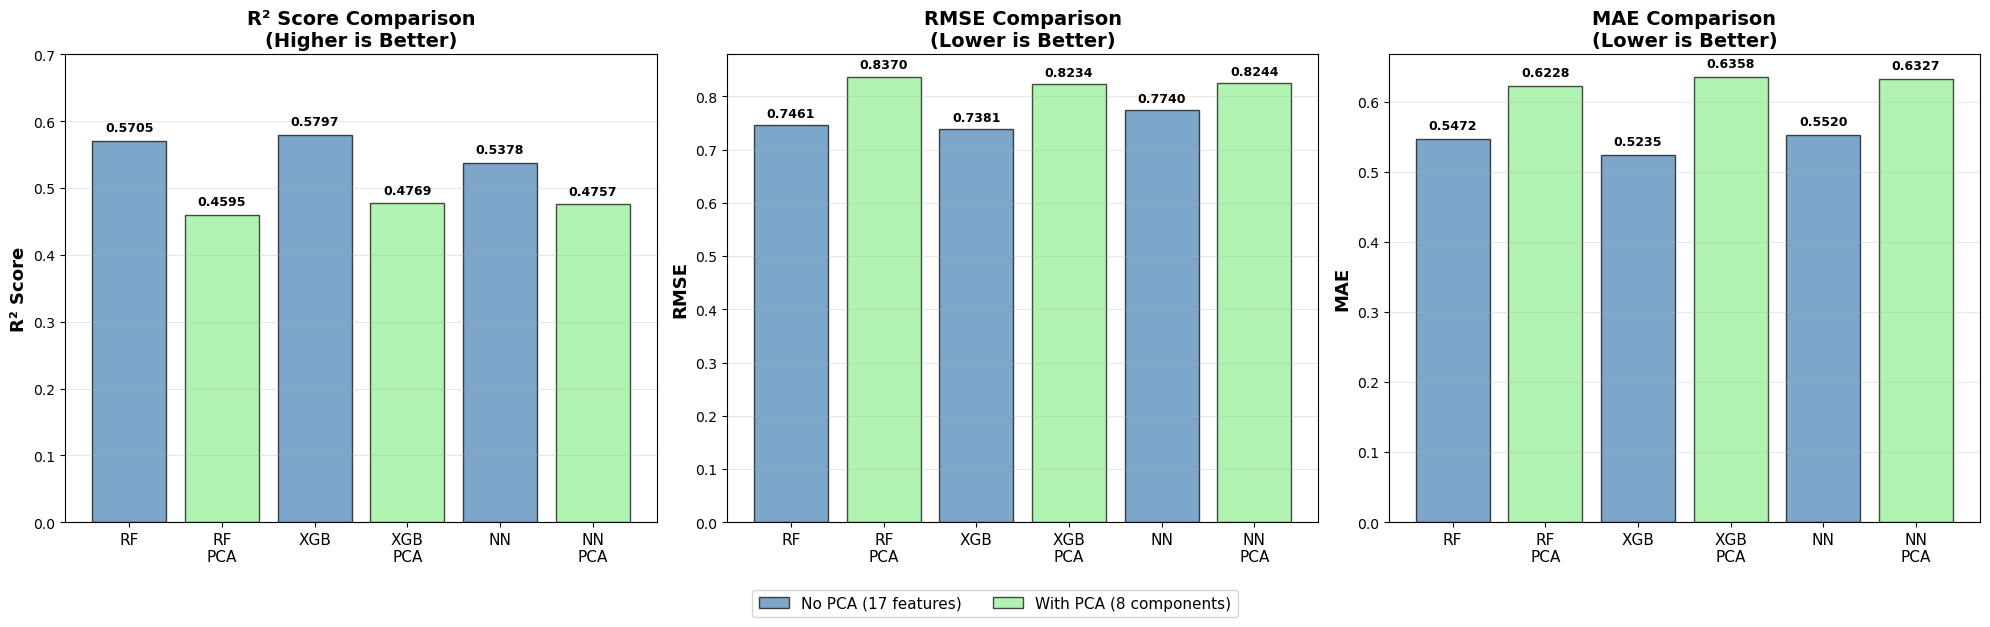

In [11]:
# Prepare data for visualization
models = comparison_data['Model'].values
r2_scores = comparison_data['R2_mean'].values
rmse_scores = comparison_data['RMSE_mean'].values
mae_scores = comparison_data['MAE_mean'].values

# Create color scheme: blue for no PCA, green for PCA
colors = ['steelblue', 'lightgreen', 'steelblue', 'lightgreen', 'steelblue', 'lightgreen']

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: R² Score (Higher is Better)
bars1 = axes[0].bar(range(len(models)), r2_scores, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(['RF', 'RF\nPCA', 'XGB', 'XGB\nPCA', 'NN', 'NN\nPCA'], fontsize=11)
axes[0].set_ylabel('R² Score', fontsize=13, fontweight='bold')
axes[0].set_title('R² Score Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 0.7])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, r2_scores)):
    axes[0].text(bar.get_x() + bar.get_width()/2., val + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: RMSE (Lower is Better)
bars2 = axes[1].bar(range(len(models)), rmse_scores, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(['RF', 'RF\nPCA', 'XGB', 'XGB\nPCA', 'NN', 'NN\nPCA'], fontsize=11)
axes[1].set_ylabel('RMSE', fontsize=13, fontweight='bold')
axes[1].set_title('RMSE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars2, rmse_scores)):
    axes[1].text(bar.get_x() + bar.get_width()/2., val + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: MAE (Lower is Better)
bars3 = axes[2].bar(range(len(models)), mae_scores, color=colors, edgecolor='black', alpha=0.7)
axes[2].set_xticks(range(len(models)))
axes[2].set_xticklabels(['RF', 'RF\nPCA', 'XGB', 'XGB\nPCA', 'NN', 'NN\nPCA'], fontsize=11)
axes[2].set_ylabel('MAE', fontsize=13, fontweight='bold')
axes[2].set_title('MAE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars3, mae_scores)):
    axes[2].text(bar.get_x() + bar.get_width()/2., val + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', alpha=0.7, label='No PCA (17 features)'),
    Patch(facecolor='lightgreen', edgecolor='black', alpha=0.7, label='With PCA (8 components)')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.02), fontsize=11)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()


## Summary and Recommendations


In [12]:
print("="*90)
print("📊 FINAL COMPARISON SUMMARY")
print("="*90)

# Identify top 3 models
top_3 = comparison_data.nlargest(3, 'R2_mean')[['Model', 'Features', 'R2_mean', 'RMSE_mean', 'MAE_mean']]

print("\n🏆 TOP 3 MODELS (by R² Score):")
print(top_3.to_string(index=False))

# Best overall
best_idx = comparison_data['R2_mean'].idxmax()
print(f"\n🥇 BEST OVERALL MODEL: {comparison_data.loc[best_idx, 'Model']}")
print(f"   R² Score: {comparison_data.loc[best_idx, 'R2_mean']:.4f}")
print(f"   RMSE: {comparison_data.loc[best_idx, 'RMSE_mean']:.4f}")
print(f"   MAE: {comparison_data.loc[best_idx, 'MAE_mean']:.4f}")
print(f"   Features: {comparison_data.loc[best_idx, 'Features']}")
print(f"   Validation: {comparison_data.loc[best_idx, 'Validation']}")

# Algorithm comparison
print(f"\n📊 ALGORITHM COMPARISON (Average across PCA/no-PCA):")
algorithm_comparison = pd.DataFrame({
    'Algorithm': ['Random Forest', 'XGBoost', 'Neural Network'],
    'Avg R²': [
        np.mean([rf_metrics['R2_mean'], rf_pca_metrics['R2_mean']]),
        np.mean([xgb_metrics['R2_mean'], xgb_pca_metrics['R2_mean']]),
        np.mean([nn_metrics['R2_mean'], nn_pca_metrics['R2_mean']])
    ],
    'Avg RMSE': [
        np.mean([rf_metrics['RMSE_mean'], rf_pca_metrics['RMSE_mean']]),
        np.mean([xgb_metrics['RMSE_mean'], xgb_pca_metrics['RMSE_mean']]),
        np.mean([nn_metrics['RMSE_mean'], nn_pca_metrics['RMSE_mean']])
    ]
})
print(algorithm_comparison.to_string(index=False))

# PCA Impact
print(f"\n🔬 PCA IMPACT ANALYSIS:")
pca_impact = pd.DataFrame({
    'Algorithm': ['Random Forest', 'XGBoost', 'Neural Network'],
    'R² w/o PCA': [rf_metrics['R2_mean'], xgb_metrics['R2_mean'], nn_metrics['R2_mean']],
    'R² w/ PCA': [rf_pca_metrics['R2_mean'], xgb_pca_metrics['R2_mean'], nn_pca_metrics['R2_mean']],
    'Change %': [
        ((rf_pca_metrics['R2_mean'] - rf_metrics['R2_mean']) / rf_metrics['R2_mean']) * 100,
        ((xgb_pca_metrics['R2_mean'] - xgb_metrics['R2_mean']) / xgb_metrics['R2_mean']) * 100,
        ((nn_pca_metrics['R2_mean'] - nn_metrics['R2_mean']) / nn_metrics['R2_mean']) * 100
    ]
})
print(pca_impact.to_string(index=False))

print(f"\n💡 KEY FINDINGS:")
print(f"\n1. BEST ALGORITHM: {algorithm_comparison.loc[algorithm_comparison['Avg R²'].idxmax(), 'Algorithm']}")
print(f"   → Consistently performs best across all configurations")

print(f"\n2. PCA EFFECTIVENESS:")
pca_helps = (pca_impact['Change %'] > 0).sum()
print(f"   → PCA improves performance in {pca_helps}/3 algorithms")
print(f"   → Feature reduction: 53% fewer features (17 → 8)")
print(f"   → Trade-off: Slight performance decrease for faster training")

print(f"\n3. VALIDATION STRATEGIES:")
print(f"   → RF (5-fold CV): Most reliable estimates for small datasets")
print(f"   → XGB/NN (splits): Better for comparing against external test sets")
print(f"   → Note: Different strategies make direct comparison challenging!")

print(f"\n4. PRACTICAL RECOMMENDATIONS:")
print(f"   ✅ For Maximum Accuracy: Use {comparison_data.loc[best_idx, 'Model']}")
print(f"   ✅ For Speed/Efficiency: Use RF + PCA or XGB + PCA")
print(f"   ✅ For Interpretability: Use RF or XGB without PCA")
print(f"   ✅ For Production: Consider ensemble of top 2-3 models")

print("\n" + "="*90)
print("✅ COMPREHENSIVE MODEL COMPARISON COMPLETE!")
print("="*90)


📊 FINAL COMPARISON SUMMARY

🏆 TOP 3 MODELS (by R² Score):
         Model Features  R2_mean  RMSE_mean  MAE_mean
       XGBoost 17 RDKit 0.579728   0.738075  0.523496
 Random Forest 17 RDKit 0.570490   0.746143  0.547204
Neural Network 17 RDKit 0.537812   0.774007  0.552021

🥇 BEST OVERALL MODEL: XGBoost
   R² Score: 0.5797
   RMSE: 0.7381
   MAE: 0.5235
   Features: 17 RDKit
   Validation: 80/20 Split

📊 ALGORITHM COMPARISON (Average across PCA/no-PCA):
     Algorithm   Avg R²  Avg RMSE
 Random Forest 0.514991  0.791582
       XGBoost 0.528339  0.780734
Neural Network 0.506758  0.799190

🔬 PCA IMPACT ANALYSIS:
     Algorithm  R² w/o PCA  R² w/ PCA   Change %
 Random Forest    0.570490   0.459493 -19.456451
       XGBoost    0.579728   0.476949 -17.728868
Neural Network    0.537812   0.475704 -11.548285

💡 KEY FINDINGS:

1. BEST ALGORITHM: XGBoost
   → Consistently performs best across all configurations

2. PCA EFFECTIVENESS:
   → PCA improves performance in 0/3 algorithms
   → Feature